In [1]:
import numpy as np
import pandas as pa
from matplotlib import pyplot as plt
import datetime
%matplotlib inline

In [2]:
df = pa.read_hdf('data.hdf')

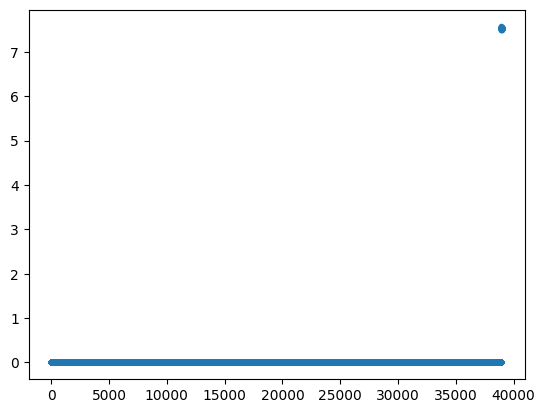

In [3]:
plt.plot(df.loc[:].average_counts,'.')
df = df.loc[:]


In [4]:
df_Sub = df.groupby(['phase_pi2_2','tau_2', 'sweeps']).average_counts.agg('mean')
max_sweep = max(df.sweeps.unique())

In [5]:
# nuclear baths
Bfield = 0.0881 # Tesla
gamma_C = 10.7 #T/MHz
gamma_Si = -8.5 #T/MHz
pi2_duration = 0.00
larmor_C = Bfield*gamma_C
larmor_Si = Bfield*gamma_Si
bath_C = 1/(4*larmor_C)
bath_Si = abs(1/(4*larmor_Si)) # is is physical to use absolute value?

print(bath_C)
print(bath_Si)

0.26520415415787074
0.33384522935167255


Freq Larmor=[943.1105 748.85   943.1105 943.1105 943.1105 943.1105 943.1105 943.1105
 943.1105 943.1105 943.1105 943.1105 748.85   748.85   748.85   748.85
 748.85   748.85   748.85   748.85   748.85   748.85   748.85   748.85
 748.85   748.85   748.85   748.85   748.85   748.85   748.85   748.85
 748.85   748.85   748.85   748.85   748.85   748.85   748.85   748.85
 748.85   748.85   748.85   748.85   748.85   748.85   748.85   748.85
 748.85   748.85   748.85   748.85  ] kHz 

Azz=[ 2.09000000e+03 -6.10000000e+02 -2.46415779e-01 -1.34386283e+01
 -7.35487067e+00 -4.67672353e+00  6.61733508e+00  5.23413339e+00
  5.36930841e+00  6.20019024e+00  1.21555538e+01 -1.74456497e+01
  5.24169986e+00  2.18631523e+00  1.87987741e+01  1.44515298e+01
  5.44206293e+00  1.61674271e+01 -5.42483281e+00 -4.93262483e+00
 -3.56079802e+00  7.44976466e+00 -7.90855640e+00 -1.94900635e+00
 -4.51575168e+00 -4.68177034e+00  4.05221739e+00  6.69145215e+00
 -8.70587861e+00 -9.19892384e-01 -4.62712401e+00 -3.44877

100%|███████████████████████████████████| 1516/1516 [00:00<00:00, 22474.30it/s]


<IPython.core.display.Javascript object>


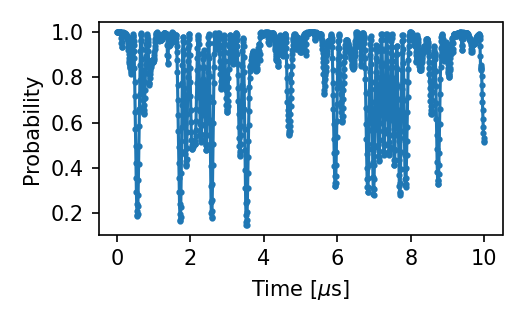

In [10]:
#######################################################################################################################
from tqdm import tqdm
from numpy import cos, sin, pi, sqrt, real, imag, matmul
# Dynamical Decoupling = DD
def DD(FL, Azz, Azx, tau, N_pi, s1=3/2, s0=1/2): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*FL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    Thet= np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot*sin(Ome0*tau)*sin(Ome1*tau))
    sigma_z = 1-2*q**2*sin(Ome0*tau/2)**2*sin(Ome1*tau/2)**2*sin(N_pi/2*Thet)**2/(cos(Thet/2)**2)
    return -np.prod(sigma_z)

start = 8e-9 # in ms
duration = 10e-3 # in ms
incre = 6.6e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 8 # number of pi pulses
N_meas = int(1e4) # number of measurements needed for noise generated signal
%matplotlib notebook
# determining the parameters
fL_C = 881*1.0705 # kHz carbon
fL_S = np.abs(-881*0.85) # kHz silicon
Azz = np.array([2.09e3, -0.61e3]) # kHz
Azx = np.array([-0.29e3, -0.15e3]) # kHz
FL= np.array([fL_C, fL_S])

num_bath = 50
num_bath_C = 10
num_bath_Si = num_bath - num_bath_C 
Azz = np.append(Azz, np.random.normal(loc= 0, scale=10, size= num_bath)) # random bath
Azx = np.append(Azx, np.random.normal(loc= 0, scale=10, size= num_bath)) # random bath
FL  = np.append(FL, np.array([fL_C]*num_bath_C))
FL  = np.append(FL, np.array([fL_S]*num_bath_Si))

s1, s0 = 3/2, 1/2
Fh_up = np.sqrt((FL+s1*Azz)**2+(s1*Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((FL+s0*Azz)**2+(s0*Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms
k_up = Azx / Fh_up
k_dn = Azx / Fh_dn
print('Freq Larmor={} kHz \n'.format(FL))
print('Azz={} kHz \n'.format(Azz))
print('Azx={} kHz \n'.format(Azx))
print('Freq hyp up={} kHz \n'.format(Fh_up))
print('Freq hyp dn={} kHz \n'.format(Fh_dn))
print('Blind Spot up={} us \n'.format(BS_up*1000))
print('Blind Spot dn={} us \n'.format(BS_dn*1000))
print('k_up={} kHz \n'.format(k_up))
print('k_dn={} kHz \n'.format(k_dn))


sigmaz_DD = []
for tau in tqdm(Taus):
    sigmaz_DD.append(DD(FL, Azz, Azx, tau, N_pi, s1=1, s0=0))
sigmaz_DD = np.array(sigmaz_DD) # signal is just sigma_z from -1 to 1
p = 0.5-0.5*sigmaz_DD #probability to be in the initial state (bright state) from 0 to 1
#p_noisy = Generate_noisy_signal(p, N_meas)

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(Taus*1000, p, '-o',markersize=2, label='DD')
plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.tight_layout()
# plt.savefig('DD_3_4pulse.png', dpi=150)
# plt.savefig('DD_3_64pulse.png', dpi=150)
# plt.savefig('DD_all_64pulse.png',dpi=150)
# plt.xlim([12.26, 12.73])
# plt.ylim([0.46, 1.03])
# plt.savefig('DD_all_64pulse_zoom.png',dpi=150)

<IPython.core.display.Javascript object>


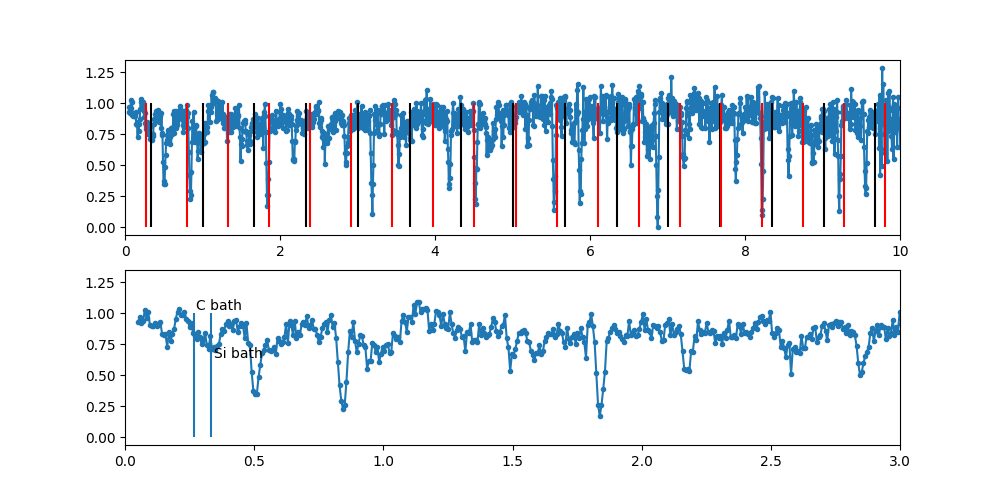

ValueError: x and y must have same first dimension, but have shapes (1516,) and (1,)

In [12]:
%matplotlib notebook
tau_2 = df.tau_2.unique()
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (10,5))
y1 = np.zeros(len(tau_2))
y2 = np.zeros(len(tau_2))
for sweep in df.sweeps.unique():  
    y1+= np.array(df_Sub.loc[0, :, sweep])
    y2+= np.array(df_Sub.loc[180, :, sweep])
y = y2-y1
y = y/max(y)
y = 0.5-0.5*y

ax1.plot(tau_2+0.05,y,'.-')
ax2.plot(tau_2+0.05,y,'.-')
ax2.vlines(bath_C,0,1)
ax2.vlines(bath_Si,0,1)
for i in range(20):
    ax1.vlines(bath_C*(2*i+1),0,1, color='red')
    ax1.vlines(bath_Si*(2*i+1),0,1, color='black')
ax2.text(bath_C+0.01, .8*max(y),'C bath')
ax2.text(bath_Si+0.01, .5*max(y),'Si bath')
ax1.set_xlim([0,10])
ax2.set_xlim([0,3])
ax1.plot(Taus*1000, p, '-o',markersize=2, label='DD')
for p in range(0, 30):
    t_reson = (2*p+1)/(4*larmor_C*1e3)
    ax1.axvline(np.abs(t_reson*1000), color='purple')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


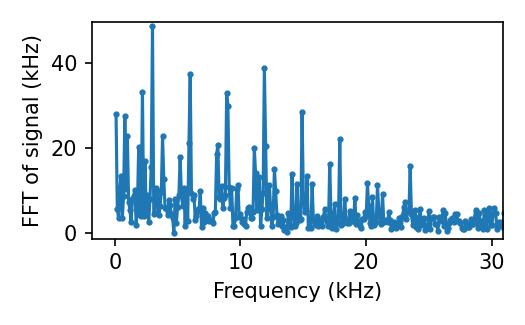

In [8]:
from scipy.fft import fft, fftfreq
steps = len(tau_2)
freqs = fftfreq(steps, tau_2[1]-tau_2[0])[1:int(steps/2)]
FFT_p = np.abs(np.fft.rfft(y))[1:int(steps/2)]
plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(freqs, FFT_p, '-o',ms=2)
plt.xlabel('Frequency (kHz)')
plt.ylabel('FFT of signal (kHz)')
plt.tight_layout()

In [9]:
tau = df.tau_2.unique()
   
y1= np.array(df_Sub.loc[0,:])
y2= np.array(df_Sub.loc[180,:])
y = y2-y1
test = y.reshape(7,100)
add = test[0]
for i in range(1,7):
    add +=test[i]
plt.plot(tau[0:100],add)
plt.vlines(bath_C,min(y),max(y))
plt.vlines(bath_Si,min(y),.5*max(y))
plt.text(bath_C+0.01, .8*max(y),'C bath')
plt.text(bath_Si-0.04, .6*max(y),'Si bath')
plt.xlabel('tau/2')
plt.show()

ValueError: cannot reshape array of size 19500 into shape (7,100)